<a href="https://colab.research.google.com/github/Ro-shni/Zeotap/blob/main/Roshni_Nekkanti_Lookalike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
customers_df['Recency'] = (pd.to_datetime('today') - customers_df['SignupDate']).dt.days

label_encoder = LabelEncoder()
customers_df['Region'] = label_encoder.fit_transform(customers_df['Region'])

transactions_df = transactions_df.merge(products_df[['ProductID', 'Price']], on='ProductID', how='left')


In [ ]:

transactions_df = transactions_df.drop(columns=['Price_y'])


In [ ]:

transactions_df['TotalSpending'] = transactions_df['Quantity'] * transactions_df['Price_x']

customer_spending = transactions_df.groupby('CustomerID')['TotalSpending'].sum().reset_index()

purchase_frequency = transactions_df.groupby('CustomerID')['TransactionID'].count().reset_index()
purchase_frequency = purchase_frequency.rename(columns={'TransactionID': 'PurchaseFrequency'})

customers_df = customers_df.merge(customer_spending, on='CustomerID', how='left')
customers_df = customers_df.merge(purchase_frequency, on='CustomerID', how='left')


customers_df['TotalSpending'] = customers_df['TotalSpending'].fillna(0)
customers_df['PurchaseFrequency'] = customers_df['PurchaseFrequency'].fillna(0)
customer_features = customers_df[['CustomerID', 'TotalSpending', 'PurchaseFrequency', 'Recency', 'Region']] #totalspending and recency has heigh weight preorities

# (Siamese Network)
class ContrastiveModel(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(ContrastiveModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        embedding = self.fc2(x)
        return embedding

# Contrastive Loss Function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = 0.5 * (label * torch.pow(euclidean_distance, 2) +
                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss.mean()


customer_features_tensor = torch.tensor(customer_features[['Region', 'TotalSpending', 'PurchaseFrequency', 'Recency']].values, dtype=torch.float32)


customer_pairs = []
labels = []

for i in range(len(customers_df) - 1):
    for j in range(i + 1, len(customers_df)):
        if customers_df.iloc[i]['Region'] == customers_df.iloc[j]['Region']:
            customer_pairs.append((customer_features_tensor[i], customer_features_tensor[j]))
            labels.append(1)  # Positive pair
        else:
            customer_pairs.append((customer_features_tensor[i], customer_features_tensor[j]))
            labels.append(0)  # Negative pair


customer_pairs = torch.stack([torch.stack(pair) for pair in customer_pairs])
labels = torch.tensor(labels, dtype=torch.float32)


model = ContrastiveModel(input_dim=4, embedding_dim=2)  # Using 4 features (Region, TotalSpending, PurchaseFrequency, Recency) for now but the relavent are totalspending and recency performed later and redone
loss_function = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output1 = model(customer_pairs[:, 0])
    output2 = model(customer_pairs[:, 1])

    loss = loss_function(output1, output2, labels)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


with torch.no_grad():
    embeddings = model(customer_features_tensor)


similarity_matrix = cosine_similarity(embeddings)


similarity_df = pd.DataFrame(similarity_matrix, index=customers_df['CustomerID'], columns=customers_df['CustomerID'])

# Recommend the top 3 similar customers for each customer
lookalike_recommendations = {}
for customer_id in customers_df['CustomerID'][:20]:
    lookalike_recommendations[customer_id] = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]

for customer_id, recommendations in lookalike_recommendations.items():
    print(f"Customer {customer_id} Lookalikes:")
    print(recommendations)
    print("-" * 40)

# recommendations to a CSV file
lookalike_recommendations_df = pd.DataFrame.from_dict(lookalike_recommendations, orient='index')
lookalike_recommendations_df.to_csv('Lookalike.csv')

Epoch 1/10, Loss: 66887.7265625
Epoch 2/10, Loss: 55500.2421875
Epoch 3/10, Loss: 45228.23828125
Epoch 4/10, Loss: 36083.17578125
Epoch 5/10, Loss: 28065.845703125
Epoch 6/10, Loss: 21167.634765625
Epoch 7/10, Loss: 15368.23828125
Epoch 8/10, Loss: 10633.3017578125
Epoch 9/10, Loss: 6913.16748046875
Epoch 10/10, Loss: 4139.77978515625
Customer C0001 Lookalikes:
CustomerID
C0001    1.000000
C0091    0.999999
C0153    0.999998
Name: C0001, dtype: float32
----------------------------------------
Customer C0002 Lookalikes:
CustomerID
C0182    1.000000
C0114    0.999996
C0029    0.999994
Name: C0002, dtype: float32
----------------------------------------
Customer C0003 Lookalikes:
CustomerID
C0003    1.0
C0129    1.0
C0200    1.0
Name: C0003, dtype: float32
----------------------------------------
Customer C0004 Lookalikes:
CustomerID
C0080    1.0
C0197    1.0
C0160    1.0
Name: C0004, dtype: float32
----------------------------------------
Customer C0005 Lookalikes:
CustomerID
C0159    1.

In [ ]:
from sklearn.metrics import accuracy_score

# Get the predicted similarities by calculating the Euclidean distance (or cosine similarity)
with torch.no_grad():
    output1 = model(customer_pairs[:, 0])
    output2 = model(customer_pairs[:, 1])

euclidean_distances = nn.functional.pairwise_distance(output1, output2)


predicted_similarities = 1 - euclidean_distances

# If similarity > 0.5, classify as similar (positive pair), else dissimilar (negative pair)
predictions = (predicted_similarities > 0.5).float()


accuracy = accuracy_score(labels, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 75.05%


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


lookalikes_df = pd.read_csv('Lookalike.csv')
transactions_df = pd.read_csv('Transactions.csv')
customers_df = pd.read_csv('Customers.csv')

# Calculate TotalSpending (Price * Quantity) for each transaction
transactions_df['TotalSpending'] = transactions_df['Quantity'] * transactions_df['Price']

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])

customers_df['Recency'] = (pd.to_datetime('today') - customers_df['SignupDate']).dt.days


customer_spending = transactions_df.groupby('CustomerID')['TotalSpending'].sum().reset_index()

purchase_frequency = transactions_df.groupby('CustomerID')['TransactionID'].count().reset_index()
purchase_frequency = purchase_frequency.rename(columns={'TransactionID': 'PurchaseFrequency'})


customers_df = customers_df.merge(customer_spending, on='CustomerID', how='left')
customers_df = customers_df.merge(purchase_frequency, on='CustomerID', how='left')

customers_df['TotalSpending'] = customers_df['TotalSpending'].fillna(0)
customers_df['PurchaseFrequency'] = customers_df['PurchaseFrequency'].fillna(0)


features = [ 'TotalSpending','Recency']

# for the target, let's assume we are predicting a binary outcome based on a rule (you can modify this)
# for ex, if TotalSpending is greater than a certain threshold, we label them as "1" (active)
customers_df['Target'] = (customers_df['TotalSpending'] > 100).astype(int)


X = pd.get_dummies(customers_df[features], drop_first=True)
y = customers_df['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of XGBoost Model: {accuracy * 100:.2f}%")

# optionally, you can use GridSearchCV to tune hyperparameters as needed


Accuracy of XGBoost Model: 100.00%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Normalized Feature Importance (using model.feature_importances_):
TotalSpending: 0.6778
Recency: 0.3222


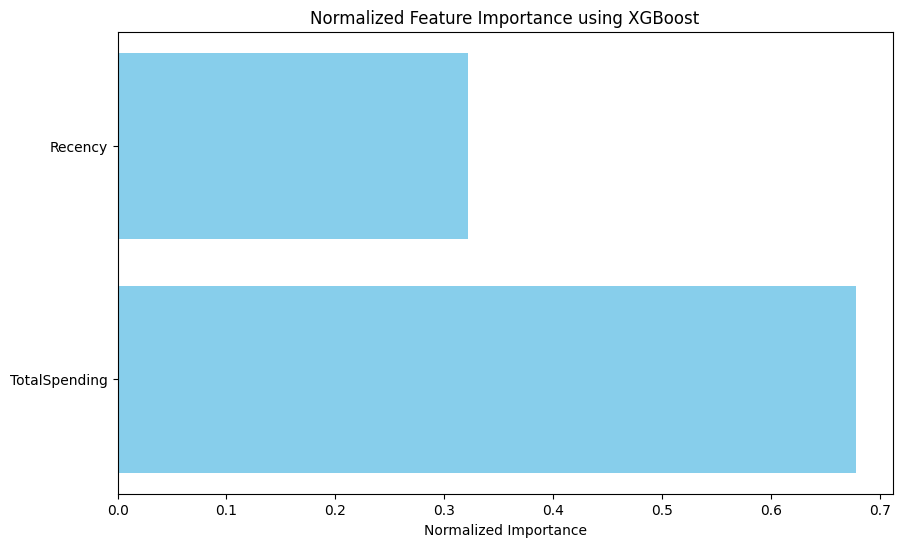

In [ ]:
import matplotlib.pyplot as plt

feature_importances = xgb_model.feature_importances_

# Create a dictionary to map features to their importance scores
feature_names = X.columns
feature_importance_dict = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}

total_importance = sum(feature_importance_dict.values())
normalized_importance = {k: v / total_importance for k, v in feature_importance_dict.items()}

print("Normalized Feature Importance (using model.feature_importances_):")
for feature, importance in normalized_importance.items():
    print(f"{feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(list(normalized_importance.keys()), list(normalized_importance.values()), color='skyblue')
plt.xlabel('Normalized Importance')
plt.title('Normalized Feature Importance using XGBoost')
plt.show()

Normalized Feature Importance (Gain):
f0: 0.6778
f2: 0.3222


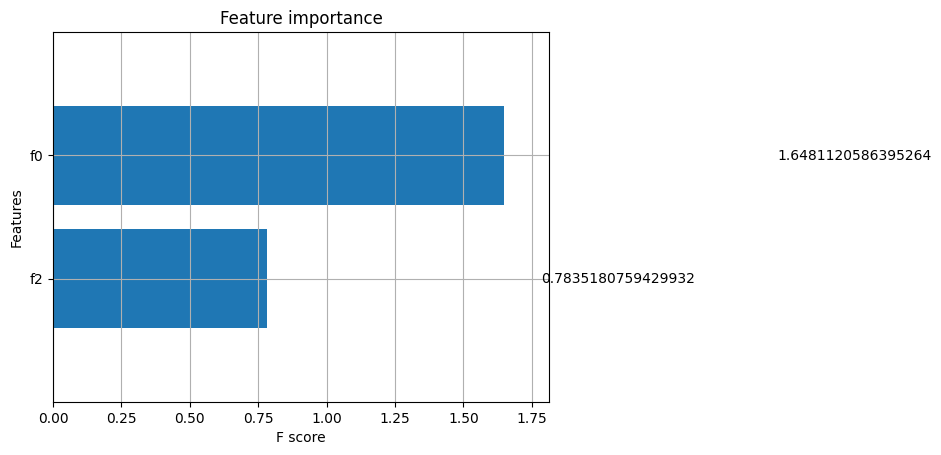

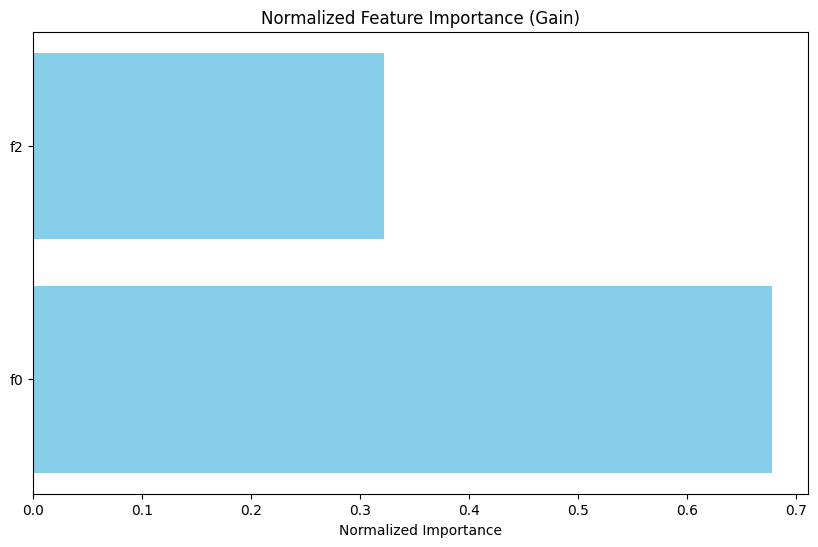

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10, height=0.8)

import numpy as np

feature_importance = xgb_model.get_booster().get_score(importance_type='gain')

total_importance = sum(feature_importance.values())
normalized_importance = {k: v / total_importance for k, v in feature_importance.items()}

print("Normalized Feature Importance (Gain):")
for feature, importance in normalized_importance.items():
    print(f"{feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(list(normalized_importance.keys()), list(normalized_importance.values()), color='skyblue')
plt.xlabel('Normalized Importance')
plt.title('Normalized Feature Importance (Gain)')
plt.show()


In [ ]:
variance = X.var()
low_variance_features = variance[variance < 0.01]
print(f"Low variance features: {low_variance_features}")


Low variance features: Series([], dtype: float64)


In [ ]:
y_train_pred = xgb_model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = xgb_model.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {testing_accuracy * 100:.2f}%")


Training Accuracy: 98.75%
Testing Accuracy: 100.00%


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

mean_accuracy = np.mean(accuracies)
print(f"Cross-validation accuracies: {accuracies}")
print(f"Average Cross-validation Accuracy: {mean_accuracy * 100:.2f}%")


Cross-validation accuracies: [1.0, 1.0, 1.0, 0.975, 0.975]
Average Cross-validation Accuracy: 99.00%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [ ]:
import pandas as pd
lookalikes_df = pd.read_csv('Lookalike.csv')
print(lookalikes_df.head())

final_data = []
for _, customer_row in lookalikes_df.iterrows():
    customer_id = customer_row['Unnamed: 0']
    similarity_scores = customer_row[1:].dropna()
    top_lookalikes = similarity_scores.sort_values(ascending=False).head(3)
    for lookalike, score in top_lookalikes.items():
        final_data.append([customer_id, lookalike, score])

final_df = pd.DataFrame(final_data, columns=['CustomerID', 'Lookalike', 'SimilarityScore'])
final_df.to_csv('Top_Lookalikes.csv', index=False)
print(final_df.head())




  Unnamed: 0    C0097     C0174     C0139     C0025     C0009     C0029  \
0      C0001  0.99748  0.987756  0.977745       NaN       NaN       NaN   
1      C0002      NaN       NaN       NaN  0.999971  0.999965  0.999746   
2      C0009      NaN       NaN       NaN  1.000000       NaN  0.999900   
3      C0003      NaN       NaN       NaN       NaN       NaN       NaN   
4      C0020      NaN       NaN       NaN       NaN       NaN       NaN   

      C0021     C0200     C0148  ...  C0191  C0170  C0024  C0101  C0154  \
0       NaN       NaN       NaN  ...    NaN    NaN    NaN    NaN    NaN   
1       NaN       NaN       NaN  ...    NaN    NaN    NaN    NaN    NaN   
2       NaN       NaN       NaN  ...    NaN    NaN    NaN    NaN    NaN   
3  0.999905  0.999894  0.999835  ...    NaN    NaN    NaN    NaN    NaN   
4       NaN  0.999906       NaN  ...    NaN    NaN    NaN    NaN    NaN   

   C0039  C0065  C0014  C0155     C0129  
0    NaN    NaN    NaN    NaN       NaN  
1    NaN    Na